In [1]:
import tensorflow as tf
print(tf.__version__)

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


2.0.0


In [2]:
# 由于inception层比较复杂，这里使用自定义一个层，这里使用tf.keras.models.Model的模型构建方法，更加灵活
class Inception(tf.keras.layers.Layer):
    def __init__(self,c1, c2, c3, c4):
        super().__init__()
        # 线路1，单1 x 1卷积层
        self.p1_1 = tf.keras.layers.Conv2D(c1, kernel_size=1, activation='relu', padding='same')
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], kernel_size=1, padding='same', activation='relu')
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], kernel_size=3, padding='same',
                              activation='relu')
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], kernel_size=1, padding='same', activation='relu')
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], kernel_size=5, padding='same',
                              activation='relu')
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = tf.keras.layers.MaxPool2D(pool_size=3, padding='same', strides=1)
        self.p4_2 = tf.keras.layers.Conv2D(c4, kernel_size=1, padding='same', activation='relu')

    def call(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        return tf.concat([p1, p2, p3, p4], axis=-1)  # 在通道维上连结输出,这里注意一下

In [3]:
Inception(64, (96, 128), (16, 32), 32)

#### GoogLeNet跟VGG一样，在主体卷积部分中使用5个模块（block），每个模块之间使用步幅为2的3×33×3最大池化层来减小输出高宽。第一模块使用一个64通道的7×77×7卷积层。

In [5]:
b1 = tf.keras.models.Sequential()
b1.add(tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', activation='relu'))
b1.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))


#### 第二模块使用2个卷积层：首先是64通道的1×11×1卷积层，然后是将通道增大3倍的3×33×3卷积层。它对应Inception块中的第二条线路。

In [6]:
b2 = tf.keras.models.Sequential()
b2.add(tf.keras.layers.Conv2D(64, kernel_size=1, padding='same', activation='relu'))
b2.add(tf.keras.layers.Conv2D(192, kernel_size=3, padding='same', activation='relu'))
b2.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))


#### 第三模块串联2个完整的Inception块。第一个Inception块的输出通道数为64+128+32+32=25664+128+32+32=256，其中4条线路的输出通道数比例为64:128:32:32=2:4:1:112832:32=241:164:128:32:32=2:4:1:1。其中第二、第三条线路先分别将输入通道数减小至96/192=1/296/192=1/2和16/192=1/1216/192=1/12后，再接上第二层卷积层。第二个Inception块输出通道数增至128+192+96+64=480128+192+96+64=480，每条线路的输出通道数之比为128:192:96:64=4:6:3:219296:64 = 463:2128:192:96:64=4:6:3:2。其中第二、第三条线路先分别将输入通道数减小至128/256=1/2128/256=1/2和32/256=1/832/256=1/8。

In [7]:
b3 = tf.keras.models.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32))
b3.add(Inception(128, (128, 192), (32, 96), 64))
b3.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))


#### 第四模块更加复杂。它串联了5个Inception块，其输出通道数分别是192+208+48+64=512192+208+48+64=512、160+224+64+64=512160+224+64+64=512、128+256+64+64=512128+256+64+64=512、112+288+64+64=528112+288+64+64=528和256+320+128+128=832256+320+128+128=832。这些线路的通道数分配和第三模块中的类似，首先含3×33×3卷积层的第二条线路输出最多通道，其次是仅含1×11×1卷积层的第一条线路，之后是含5×55×5卷积层的第三条线路和含3×33×3最大池化层的第四条线路。其中第二、第三条线路都会先按比例减小通道数。这些比例在各个Inception块中都略有不同。

In [8]:
b4 = tf.keras.models.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64))
b4.add(Inception(160, (112, 224), (24, 64), 64))
b4.add(Inception(128, (128, 256), (24, 64), 64))
b4.add(Inception(112, (144, 288), (32, 64), 64))
b4.add(Inception(256, (160, 320), (32, 128), 128))
b4.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))


#### 第五模块有输出通道数为256+320+128+128=832256+320+128+128=832和384+384+128+128=1024384+384+128+128=1024的两个Inception块。其中每条线路的通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。需要注意的是，第五模块的后面紧跟输出层，该模块同NiN一样使用全局平均池化层来将每个通道的高和宽变成1。最后我们将输出变成二维数组后接上一个输出个数为标签类别数的全连接层。

In [9]:
b5 = tf.keras.models.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128))
b5.add(Inception(384, (192, 384), (48, 128), 128))
b5.add(tf.keras.layers.GlobalAvgPool2D())

net = tf.keras.models.Sequential([b1, b2, b3, b4, b5, tf.keras.layers.Dense(10, activation='softmax')])


#### GoogLeNet模型的计算复杂，而且不如VGG那样便于修改通道数。本节里我们将输入的高和宽从224降到96来简化计算。下面演示各个模块之间的输出的形状变化。

In [10]:
X = tf.random.uniform(shape=(1, 96, 96, 1))
for layer in net.layers:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)


sequential output shape:	 (1, 24, 24, 64)
sequential_1 output shape:	 (1, 12, 12, 192)
sequential_2 output shape:	 (1, 6, 6, 480)
sequential_3 output shape:	 (1, 3, 3, 832)
sequential_4 output shape:	 (1, 1024)
dense output shape:	 (1, 10)


In [11]:
# 获取数据
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


# 数据预处理
def data_scale(x, y):
    x = tf.cast(x, tf.float32)
    x = x / 255.0
    x = tf.reshape(x, (x.shape[0], x.shape[1], 1))
    x = tf.image.resize_with_pad(image=x, target_height=224,target_width=224)

    return x, y
# 由于笔记本训练太慢了，使用1000条数据，跑一下先,算力够的可以直接使用全部数据更加明显
train_db = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(20).map(data_scale).batch(64)
test_db = tf.data.Dataset.from_tensor_slices((x_test,y_test)).shuffle(20).map(data_scale).batch(64)

In [12]:
# 定义优化器和损失函数
optimizer = tf.keras.optimizers.SGD(lr=1e-1)
loss = tf.keras.losses.sparse_categorical_crossentropy
net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [13]:
net.fit_generator(train_db, epochs=10, validation_data=test_db)    # 这里就不跑太多轮了，有机器可以自己调参跑个好的结果
net.summary()

Epoch 1/10
938/938 [==============================] - 156s 167ms/step - loss: 1.5030 - accuracy: 0.2559 - val_loss: 0.8437 - val_accuracy: 0.6930
Epoch 2/10
938/938 [==============================] - 155s 165ms/step - loss: 0.6259 - accuracy: 0.7148 - val_loss: 0.5670 - val_accuracy: 0.7986
Epoch 3/10
938/938 [==============================] - 155s 165ms/step - loss: 0.4225 - accuracy: 0.8329 - val_loss: 0.3996 - val_accuracy: 0.8522
Epoch 4/10
938/938 [==============================] - 155s 166ms/step - loss: 0.3482 - accuracy: 0.8660 - val_loss: 0.3346 - val_accuracy: 0.8742
Epoch 5/10
938/938 [==============================] - 155s 165ms/step - loss: 0.3069 - accuracy: 0.8826 - val_loss: 0.3714 - val_accuracy: 0.8569
Epoch 6/10
938/938 [==============================] - 155s 165ms/step - loss: 0.2799 - accuracy: 0.8934 - val_loss: 0.3259 - val_accuracy: 0.8769
Epoch 7/10
938/938 [==============================] - 155s 165ms/step - loss: 0.2560 - accuracy: 0.9019 - val_loss: 0.2908 -

sequential itput shape:	 (1, 224, 224, 1)
sequential output shape:	 (1, 56, 56, 64)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
sequential_1 itput shape:	 (1, 56, 56, 64)
sequential_1 output shape:	 (1, 28, 28, 192)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
sequential_2 itput shape:	 (1, 28, 28, 192)
sequential_2 output shape:	 (1, 14, 14, 480)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
sequential_3 itput shape:	 (1, 14, 14, 480)
sequential_3 output shape:	 (1, 7, 7, 832)
(7, 7)
(7, 7)
(7, 7)
(7, 7)


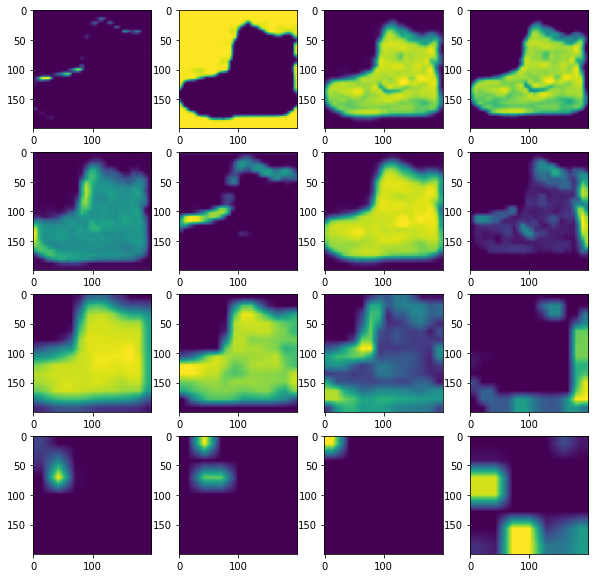

In [70]:
# 展示其中的前八层的特征图
X = next(iter(train_db))[0][0]

def show(X, k,i):
    print(X.shape)
    X = tf.expand_dims(X, axis=-1)
    # 将每个图转换为 200 * 200的像素，但这个不是图大小
    X = tf.image.resize(X,  [200,200], method='bilinear')
    X_ = tf.squeeze(X)
    plt.subplot(4, 4,  4*k + i + 1)
    plt.imshow(X_)


X = tf.expand_dims(X, axis=0)

# 设置图纸大小
plt.figure(figsize=(10, 10))
# 打印前 4 层的部分特征图
for k,blk in enumerate(net.layers[0:4]):
    print(blk.name,'itput shape:\t',X.shape)
#     show(X[0,:,:,0])
    X = blk(X)

    print(blk.name, 'output shape:\t', X.shape)
    for i in range(4):
        show(X[0,:,:,i], k, i)

plt.show()